In [38]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import itertools
import tensorflow as tf
from tqdm import tqdm

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [6]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz


In [7]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force: #See if root is an existing directory and if force = False
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [8]:
for folder in train_folders:
    display(Image(filename = os.path.join(folder,os.listdir(folder)[np.random.randint(0,100)])))

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickl

In [10]:
train_datasets

['./notMNIST_large/A.pickle',
 './notMNIST_large/B.pickle',
 './notMNIST_large/C.pickle',
 './notMNIST_large/D.pickle',
 './notMNIST_large/E.pickle',
 './notMNIST_large/F.pickle',
 './notMNIST_large/G.pickle',
 './notMNIST_large/H.pickle',
 './notMNIST_large/I.pickle',
 './notMNIST_large/J.pickle']

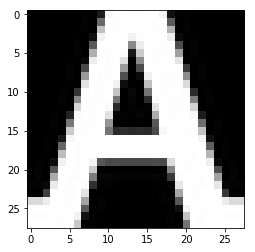

In [11]:
import matplotlib.cm as cm
pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image, cmap = cm.Greys_r)  # display it



Letter = J 




Letter = G 




Letter = I 




Letter = E 




Letter = D 




Letter = J 




Letter = D 




Letter = F 




Letter = C 




Letter = G 




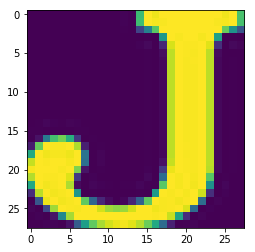

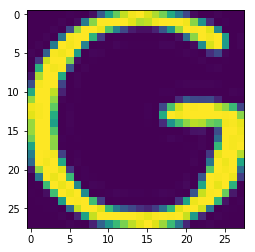

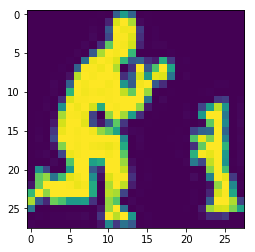

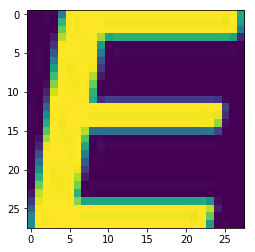

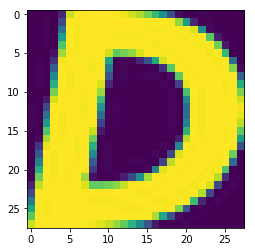

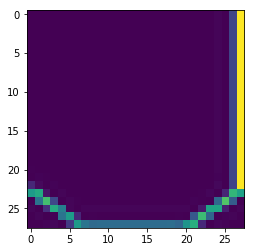

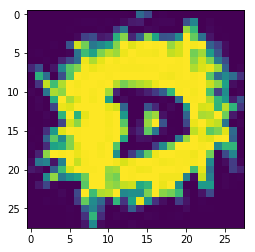

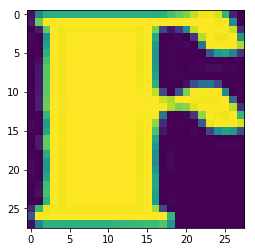

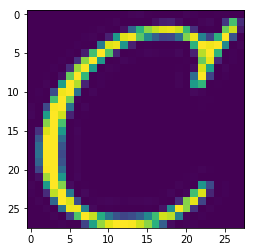

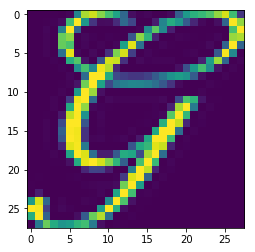

In [12]:
num_show = 10

for i in range(num_show):
    dataset = train_datasets[np.random.choice(np.arange(num_classes))]
    imgs = pickle.load( open( dataset, "rb" ) )
    letter = str(os.path.splitext(dataset)[0][-1])
    print ('\n\nLetter = %s \n\n' % letter)
    plt.figure()
    plt.imshow(imgs[np.random.choice(np.arange(len(imgs)))])


In [13]:
min_imgs = np.inf
for i in range(num_classes):
    dataset = train_datasets[i]
    imgs = pickle.load( open( dataset, "rb" ) )
    if len(imgs) < min_imgs:
        min_imgs = len(imgs) 
    print ('Dataset %s has %d images' % (dataset, len(imgs)))
min_imgs
for i in range(num_classes):
    dataset = train_datasets[i]
    imgs = pickle.load( open( dataset, "rb" ) )
    if len(imgs) < min_imgs:
        min_imgs = len(imgs) 
    print ('Dataset %s has %d images' % (dataset, len(imgs)))


Dataset ./notMNIST_large/A.pickle has 52909 images
Dataset ./notMNIST_large/B.pickle has 52911 images
Dataset ./notMNIST_large/C.pickle has 52912 images
Dataset ./notMNIST_large/D.pickle has 52911 images
Dataset ./notMNIST_large/E.pickle has 52912 images
Dataset ./notMNIST_large/F.pickle has 52912 images
Dataset ./notMNIST_large/G.pickle has 52912 images
Dataset ./notMNIST_large/H.pickle has 52912 images
Dataset ./notMNIST_large/I.pickle has 52912 images
Dataset ./notMNIST_large/J.pickle has 52911 images
Dataset ./notMNIST_large/A.pickle has 52909 images
Dataset ./notMNIST_large/B.pickle has 52911 images
Dataset ./notMNIST_large/C.pickle has 52912 images
Dataset ./notMNIST_large/D.pickle has 52911 images
Dataset ./notMNIST_large/E.pickle has 52912 images
Dataset ./notMNIST_large/F.pickle has 52912 images
Dataset ./notMNIST_large/G.pickle has 52912 images
Dataset ./notMNIST_large/H.pickle has 52912 images
Dataset ./notMNIST_large/I.pickle has 52912 images
Dataset ./notMNIST_large/J.pick

In [14]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)


In [16]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [198]:
# Getting statistics of a file using os.stat(file_name)
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 690800506


In [199]:
train_dataset.flags.writeable

True

In [201]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))


Number of overlaps between training and test sets: 1149. Execution time: 0.45802600000001803.
Number of overlaps between training and validation sets: 976. Execution time: 0.4635319999999865.
Number of overlaps between validation and test sets: 64. Execution time: 0.041805000000067594.


In [203]:
A = np.array([[1,2,1],[1,3,1]])

In [204]:
A

array([[1, 2, 1],
       [1, 3, 1]])

In [251]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics
start = time.time()

ns = [50, 100, 1000, 5000]
for n in ns:

    X_train = train_dataset[:n]
    y_train = train_labels[:n]
    train_n, width, height = X_train.shape
    X_train = X_train.reshape((train_n, width * height))

    X_test = test_dataset
    y_test = test_labels
    test_n, width, height = X_test.shape
    X_test = X_test.reshape((test_n, width * height))

    lr = LR(multi_class = 'multinomial', solver = 'lbfgs', verbose = 1, max_iter = 1000,random_state = 42, n_jobs = -1)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    acc = metrics.accuracy_score(y_test, predictions)
    print ("N = {}\nAccuracy = {} \nTime taken = {}".format(n,acc, time.time() - start))

# n_list = [50,100,1000,5000]
# # n = 50
# for n in n_list:
#     lr = LR(multi_class = 'multinomial', solver = 'lbfgs', n_jobs = -1)
#     X_train = train_dataset[:n]
#     y_train = train_labels[:n]
#     n, k1, k2 = X_train.shape
#     k = k1 * k2
#     X_train = X_train.reshape(n, k)

#     lr.fit(X, y)
#     time.time() - start

#     X_test = test_dataset
#     y_test = test_labels
#     n1, k1, k2 = X_test.shape
#     X_test = X_test.reshape(n1, k)

#     logits = lr.predict(X_test)
#     acc = metrics.accuracy_score(y_test, logits)
#     print ('Acc = {}'.format( acc))

N = 50
Accuracy = 0.5975 
Time taken = 0.34679293632507324


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


N = 100
Accuracy = 0.7226 
Time taken = 0.7031941413879395


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


N = 1000
Accuracy = 0.842 
Time taken = 1.88157320022583


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


N = 5000
Accuracy = 0.8392 
Time taken = 12.945788145065308


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.8s finished


In [255]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range


In [20]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [21]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [269]:
train_subset = 10000 #Batch size, I think

graph = tf.Graph()
with graph.as_default():
    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)


In [270]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


Initialized
Loss at step 0: 16.979116
Training accuracy: 8.5%
Validation accuracy: 11.7%
Loss at step 100: 2.339536
Training accuracy: 71.3%
Validation accuracy: 70.6%
Loss at step 200: 1.874211
Training accuracy: 74.4%
Validation accuracy: 73.0%
Loss at step 300: 1.625849
Training accuracy: 75.9%
Validation accuracy: 73.8%
Loss at step 400: 1.460141
Training accuracy: 76.8%
Validation accuracy: 74.3%
Loss at step 500: 1.337100
Training accuracy: 77.7%
Validation accuracy: 74.6%
Loss at step 600: 1.240168
Training accuracy: 78.1%
Validation accuracy: 74.9%
Loss at step 700: 1.160873
Training accuracy: 78.6%
Validation accuracy: 75.3%
Loss at step 800: 1.094540
Training accuracy: 79.1%
Validation accuracy: 75.5%
Test accuracy: 82.7%


In [25]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)


In [27]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 16.369751
Minibatch accuracy: 6.2%
Validation accuracy: 17.2%
Minibatch loss at step 500: 2.359363
Minibatch accuracy: 71.9%
Validation accuracy: 75.5%
Minibatch loss at step 1000: 1.492037
Minibatch accuracy: 79.7%
Validation accuracy: 77.1%
Minibatch loss at step 1500: 1.291395
Minibatch accuracy: 78.1%
Validation accuracy: 78.2%
Minibatch loss at step 2000: 1.036627
Minibatch accuracy: 81.2%
Validation accuracy: 77.2%
Minibatch loss at step 2500: 1.260880
Minibatch accuracy: 69.5%
Validation accuracy: 79.2%
Minibatch loss at step 3000: 0.891324
Minibatch accuracy: 76.6%
Validation accuracy: 79.2%
Test accuracy: 86.4%


In [286]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases = tf.Variable(tf.zeros([hidden_nodes]))

    weights1 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases1 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    logits = tf.matmul(h1, weights1) + biases1
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases, weights1) + biases1))
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases, weights1) + biases1))

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 479.485657
Minibatch accuracy: 5.5%
Validation accuracy: 35.8%
Minibatch loss at step 500: 81.473755
Minibatch accuracy: 58.6%
Validation accuracy: 68.8%
Minibatch loss at step 1000: 41.340561
Minibatch accuracy: 68.8%
Validation accuracy: 67.5%
Minibatch loss at step 1500: 33.019066
Minibatch accuracy: 73.4%
Validation accuracy: 75.5%
Minibatch loss at step 2000: 28.761848
Minibatch accuracy: 71.1%
Validation accuracy: 72.1%
Minibatch loss at step 2500: 40.956177
Minibatch accuracy: 67.2%
Validation accuracy: 70.5%
Minibatch loss at step 3000: 18.476761
Minibatch accuracy: 75.8%
Validation accuracy: 69.9%
Test accuracy: 76.0%


In [301]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases = tf.Variable(tf.zeros([hidden_nodes]))

    weights1 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases1 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    logits = tf.matmul(h1, weights1) + biases1
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), weights1) + biases1)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), weights1) + biases1)

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  saver = tf.train.Saver()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  save_path = saver.save(session, 'notMNIST.ckpt')
  print("Model saved in file: %s" % save_path)

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 358.088013
Minibatch accuracy: 7.0%
Validation accuracy: 32.1%
Minibatch loss at step 500: 90.119164
Minibatch accuracy: 57.8%
Validation accuracy: 73.3%
Minibatch loss at step 1000: 6.512262
Minibatch accuracy: 78.9%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 5.539775
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 19.876312
Minibatch accuracy: 79.7%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 6.264662
Minibatch accuracy: 79.7%
Validation accuracy: 83.2%
Minibatch loss at step 3000: 1.903631
Minibatch accuracy: 87.5%
Validation accuracy: 81.3%
Model saved in file: notMNIST.ckpt
Test accuracy: 87.6%


In [324]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [344]:
graph = tf.Graph()
batch_n = 5000
new_dataset = test_dataset[:batch_n] + np.random.normal(scale = .05, size = test_dataset[:batch_n].shape)
new_labels = test_labels[:batch_n]
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_test_dataset = tf.constant(test_dataset)
    tf_new_dataset = tf.constant(new_dataset, dtype = tf.float32)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases = tf.Variable(tf.zeros([hidden_nodes]))

    weights1 = tf.Variable(
        tf.truncated_normal([hidden_nodes, num_labels]))
    biases1 = tf.Variable(tf.zeros([num_labels]))

    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), weights1) + biases1)
    new_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_new_dataset, weights) + biases), weights1) + biases1)

with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, './notMNIST.ckpt')
    print ('model recovered')
    
    preds = new_prediction.eval()
    print ('Accuracy for new preds = {}'.format(accuracy(preds, new_labels)))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction[:batch_n].eval(), test_labels[:batch_n]))


model recovered
Accuracy for new preds = 86.46
Test accuracy: 87.4%


In [17]:
# # These are all the modules we'll be using later. Make sure you can import them
# # before proceeding further.
# from __future__ import print_function
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import sys
# import tarfile
# from IPython.display import display, Image
# from scipy import ndimage
# from sklearn.linear_model import LogisticRegression
# from six.moves.urllib.request import urlretrieve
# from six.moves import cPickle as pickle
# import itertools

# # Config the matplotlib backend as plotting inline in IPython
# %matplotlib inline

# url = 'http://commondatastorage.googleapis.com/books1000/'
# last_percent_reported = None
# data_root = '.' # Change me to store data elsewhere

# def download_progress_hook(count, blockSize, totalSize):
#   """A hook to report the progress of a download. This is mostly intended for users with
#   slow internet connections. Reports every 5% change in download progress.
#   """
#   global last_percent_reported
#   percent = int(count * blockSize * 100 / totalSize)

#   if last_percent_reported != percent:
#     if percent % 5 == 0:
#       sys.stdout.write("%s%%" % percent)
#       sys.stdout.flush()
#     else:
#       sys.stdout.write(".")
#       sys.stdout.flush()
      
#     last_percent_reported = percent
        
# def maybe_download(filename, expected_bytes, force=False):
#   """Download a file if not present, and make sure it's the right size."""
#   dest_filename = os.path.join(data_root, filename)
#   if force or not os.path.exists(dest_filename):
#     print('Attempting to download:', filename) 
#     filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
#     print('\nDownload Complete!')
#   statinfo = os.stat(dest_filename)
#   if statinfo.st_size == expected_bytes:
#     print('Found and verified', dest_filename)
#   else:
#     raise Exception(
#       'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
#   return dest_filename

# train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
# test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

# num_classes = 10
# np.random.seed(133)

# def maybe_extract(filename, force=False):
#   root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
#   if os.path.isdir(root) and not force: #See if root is an existing directory and if force = False
#     # You may override by setting force=True.
#     print('%s already present - Skipping extraction of %s.' % (root, filename))
#   else:
#     print('Extracting data for %s. This may take a while. Please wait.' % root)
#     tar = tarfile.open(filename)
#     sys.stdout.flush()
#     tar.extractall(data_root)
#     tar.close()
#   data_folders = [
#     os.path.join(root, d) for d in sorted(os.listdir(root))
#     if os.path.isdir(os.path.join(root, d))]
#   if len(data_folders) != num_classes:
#     raise Exception(
#       'Expected %d folders, one per class. Found %d instead.' % (
#         num_classes, len(data_folders)))
#   print(data_folders)
#   return data_folders
  
# train_folders = maybe_extract(train_filename)
# test_folders = maybe_extract(test_filename)

# image_size = 28  # Pixel width and height.
# pixel_depth = 255.0  # Number of levels per pixel.

# def load_letter(folder, min_num_images):
#   """Load the data for a single letter label."""
#   image_files = os.listdir(folder)
#   dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
#                          dtype=np.float32)
#   print(folder)
#   num_images = 0
#   for image in image_files:
#     image_file = os.path.join(folder, image)
#     try:
#       image_data = (ndimage.imread(image_file).astype(float) - 
#                     pixel_depth / 2) / pixel_depth
#       if image_data.shape != (image_size, image_size):
#         raise Exception('Unexpected image shape: %s' % str(image_data.shape))
#       dataset[num_images, :, :] = image_data
#       num_images = num_images + 1
#     except IOError as e:
#       print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
#   dataset = dataset[0:num_images, :, :]
#   if num_images < min_num_images:
#     raise Exception('Many fewer images than expected: %d < %d' %
#                     (num_images, min_num_images))
    
#   print('Full dataset tensor:', dataset.shape)
#   print('Mean:', np.mean(dataset))
#   print('Standard deviation:', np.std(dataset))
#   return dataset
        
# def maybe_pickle(data_folders, min_num_images_per_class, force=False):
#   dataset_names = []
#   for folder in data_folders:
#     set_filename = folder + '.pickle'
#     dataset_names.append(set_filename)
#     if os.path.exists(set_filename) and not force:
#       # You may override by setting force=True.
#       print('%s already present - Skipping pickling.' % set_filename)
#     else:
#       print('Pickling %s.' % set_filename)
#       dataset = load_letter(folder, min_num_images_per_class)
#       try:
#         with open(set_filename, 'wb') as f:
#           pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
#       except Exception as e:
#         print('Unable to save data to', set_filename, ':', e)
  
#   return dataset_names

# train_datasets = maybe_pickle(train_folders, 45000)
# test_datasets = maybe_pickle(test_folders, 1800)

# def make_arrays(nb_rows, img_size):
#   if nb_rows:
#     dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
#     labels = np.ndarray(nb_rows, dtype=np.int32)
#   else:
#     dataset, labels = None, None
#   return dataset, labels

# def merge_datasets(pickle_files, train_size, valid_size=0):
#   num_classes = len(pickle_files)
#   valid_dataset, valid_labels = make_arrays(valid_size, image_size)
#   train_dataset, train_labels = make_arrays(train_size, image_size)
#   vsize_per_class = valid_size // num_classes
#   tsize_per_class = train_size // num_classes
    
#   start_v, start_t = 0, 0
#   end_v, end_t = vsize_per_class, tsize_per_class
#   end_l = vsize_per_class+tsize_per_class
#   for label, pickle_file in enumerate(pickle_files):       
#     try:
#       with open(pickle_file, 'rb') as f:
#         letter_set = pickle.load(f)
#         # let's shuffle the letters to have random validation and training set
#         np.random.shuffle(letter_set)
#         if valid_dataset is not None:
#           valid_letter = letter_set[:vsize_per_class, :, :]
#           valid_dataset[start_v:end_v, :, :] = valid_letter
#           valid_labels[start_v:end_v] = label
#           start_v += vsize_per_class
#           end_v += vsize_per_class
                    
#         train_letter = letter_set[vsize_per_class:end_l, :, :]
#         train_dataset[start_t:end_t, :, :] = train_letter
#         train_labels[start_t:end_t] = label
#         start_t += tsize_per_class
#         end_t += tsize_per_class
#     except Exception as e:
#       print('Unable to process data from', pickle_file, ':', e)
#       raise
    
#   return valid_dataset, valid_labels, train_dataset, train_labels
            
            
# train_size = 200000
# valid_size = 10000
# test_size = 10000

# valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
#   train_datasets, train_size, valid_size)
# _, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

# print('Training:', train_dataset.shape, train_labels.shape)
# print('Validation:', valid_dataset.shape, valid_labels.shape)
# print('Testing:', test_dataset.shape, test_labels.shape)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz
./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']
./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping p

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import legacy_seq2seq

import numpy as np


In [ ]:
batch_size = 10
sequence_length = 10
state_dim = 128
num_layers = 2
tf.reset_default_graph()

in_ph
targ_ph

cell1 = rnn.BasicLSTMCell(state_dim)
cell2 = rnn.BasicLSTMCell(state_dim)
multicell = rnn.MultiRNNCell( [cell1,cell2], state_is_tuple=True)
initial_state = multicell.zero_state(batch_size, tf.float32)


rnn_out, final_state = legacy_seq2seq.rnn_decoder(inputs, initial_state, multicell)
logits = []
W = tf.Variable(tf.truncated_normal([state_dim, vocab_size]), dtype = tf.float32)
b = tf.Variable(tf.ones(vocab_size)*0.1, dtype = tf.float32)
for rnn in rnn_out:
    logit = tf.matmul(rnn, W) + b
    logits.append(logit)

ones_list = []
for i in xrange(batch_size):
    ones_list.append(1.)
loss = legacy_seq2seq.sequence_loss(logits, targets, ones_list)

optim = tf.train.AdamOptimizer(.001).minimize(loss)

tf.get_variable_scope().reuse_variables()

tf.get_variable_scope().reuse_variables()



s_initial_state = multicell.zero_state(1, tf.float32)
s_in_ph = tf.placeholder( tf.int32, [ 1 ], name='s_in_ph' )
s_inputs = tf.one_hot( s_in_ph, vocab_size, name="s_inputs" )
s_rnn_out, s_final_state = legacy_seq2seq.rnn_decoder([s_inputs,], s_initial_state, multicell)

s_logits = tf.matmul(s_rnn_out[0], W) + b
s_probs = tf.nn.softmax(s_logits)


In [4]:
list1 = [1,2,3]
list2 = [4,5,6]
list1.extend(list2)

In [2]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [64]:
tf.reset_default_graph()

# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 5
state_size = 16
learning_rate = 0.1
n_time_series = 4

def gen_data(n_periods=1000000, n_time_series = n_time_series):
    """
    Generates n_time_series time series that each last for n_periods periods along with a single 
    time series that lasts n_periods periods. This data generator was built for a neural net that maps 
    panel data to a single dependent variable. 
    
    args:
        
        n_periods: scalar, number of periods desired/total data points generated
        n_time_series: scalar, number of time series desired for panel data
        
    returns:
    
        X: randomly generated panel data
        Y: the sum of all panel data
    """
    X = np.random.randint(0,10,(n_time_series,n_periods))
    Y = np.sum(X, axis = 0)   
    return X, Y

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    #Raw x and y, X n_time_series by n_periods, Y n_periods long
    raw_x, raw_y = raw_data
    print (raw_x)
    print (raw_y)
    data_length = len(raw_y)
#     print (data_length)

    # partition raw data into batches and stack them vertically in a data matrix
    # batch partition length is how long each series must be in order for all series to be the same length given 
    # a data_length and batch size. 
    batch_partition_length = data_length // batch_size
    # Empty matrices to fill with data
    data_x = np.zeros([batch_size, batch_partition_length, n_time_series], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        #Fill each row of data_x and data_y with the appropriate number of 
        data_x[i] = raw_x[:, batch_partition_length * i:batch_partition_length * (i + 1)].T
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    # Each of these are just truncated sequences, split up along the first axis, which is the time dimension.
    epoch_size = batch_partition_length // num_steps
    
    #epoch size is 500
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [67]:
num_epochs = 1
for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
    for step, (X, Y) in enumerate(epoch):
        print (X.shape,Y.shape)
        print (step)

[[1 9 5 ..., 5 2 9]
 [6 3 0 ..., 0 0 7]
 [0 1 7 ..., 7 2 6]
 [9 7 0 ..., 3 1 0]]
[16 20 12 ..., 15  5 22]
(200, 10, 4) (200, 10)
0
(200, 10, 4) (200, 10)
1
(200, 10, 4) (200, 10)
2
(200, 10, 4) (200, 10)
3
(200, 10, 4) (200, 10)
4
(200, 10, 4) (200, 10)
5
(200, 10, 4) (200, 10)
6
(200, 10, 4) (200, 10)
7
(200, 10, 4) (200, 10)
8
(200, 10, 4) (200, 10)
9
(200, 10, 4) (200, 10)
10
(200, 10, 4) (200, 10)
11
(200, 10, 4) (200, 10)
12
(200, 10, 4) (200, 10)
13
(200, 10, 4) (200, 10)
14
(200, 10, 4) (200, 10)
15
(200, 10, 4) (200, 10)
16
(200, 10, 4) (200, 10)
17
(200, 10, 4) (200, 10)
18
(200, 10, 4) (200, 10)
19
(200, 10, 4) (200, 10)
20
(200, 10, 4) (200, 10)
21
(200, 10, 4) (200, 10)
22
(200, 10, 4) (200, 10)
23
(200, 10, 4) (200, 10)
24
(200, 10, 4) (200, 10)
25
(200, 10, 4) (200, 10)
26
(200, 10, 4) (200, 10)
27
(200, 10, 4) (200, 10)
28
(200, 10, 4) (200, 10)
29
(200, 10, 4) (200, 10)
30
(200, 10, 4) (200, 10)
31
(200, 10, 4) (200, 10)
32
(200, 10, 4) (200, 10)
33
(200, 10, 4) (200, 1

In [79]:
"""
Placeholders
"""
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, [batch_size, num_steps,n_time_series], name='input_placeholder')
    y = tf.placeholder(tf.float32, [batch_size, num_steps], name='labels_placeholder')
    init_state = tf.zeros([batch_size, state_size])

    """
    RNN Inputs
    """

    # Turn our x placeholder into a list of one-hot tensors:
    # rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
    rnn_inputs = tf.unstack(x, axis=1)

    """
    Definition of rnn_cell

    This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
    """
    with tf.variable_scope('rnn_cell'):
        W = tf.get_variable('W', [n_time_series + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

    def rnn_cell(rnn_input, state):
        with tf.variable_scope('rnn_cell', reuse=True):
            W = tf.get_variable('W', [n_time_series + state_size, state_size])
            b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)


    """
    Adding rnn_cells to graph

    This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
    Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
    """
    state = init_state
    rnn_outputs = []
    for rnn_input in rnn_inputs:
        state = rnn_cell(rnn_input, state)
        rnn_outputs.append(state)
    final_state = rnn_outputs[-1]


    """
    Predictions, loss, training step

    Losses is similar to the "sequence_loss"
    function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
    """

    #logits and predictions
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, 1])
        b = tf.get_variable('b', [1], initializer=tf.constant_initializer(0.0))
    predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

    # Turn our y placeholder into a list of labels
    y_as_list = tf.unstack(y, num=num_steps, axis=1)
    print (y_as_list[0], predictions[0])
    #losses and train_step
    losses = [tf.nn.l2_loss(actual - prediction) for \
              prediction, actual in zip(predictions, y_as_list)]
    total_loss = tf.reduce_mean(losses)
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

Tensor("unstack_1:0", shape=(200,), dtype=float32) Tensor("add_10:0", shape=(200, 1), dtype=float32)


In [81]:
num_epochs

1


EPOCH 0
[[0 2 8 ..., 2 0 2]
 [1 4 0 ..., 2 0 3]
 [7 7 9 ..., 6 6 7]
 [7 8 4 ..., 1 2 7]]
[15 21 21 ..., 11  8 19]
Average loss at step 100 for last 250 steps: 1036264.48438
Average loss at step 200 for last 250 steps: 658809.459375
Average loss at step 300 for last 250 steps: 659685.135625
Average loss at step 400 for last 250 steps: 661198.238125

EPOCH 1
[[7 1 3 ..., 0 2 6]
 [0 5 2 ..., 8 3 5]
 [4 9 6 ..., 0 6 7]
 [9 5 2 ..., 8 5 9]]
[20 20 13 ..., 16 16 27]
Average loss at step 100 for last 250 steps: 667694.606875
Average loss at step 200 for last 250 steps: 659888.958125
Average loss at step 300 for last 250 steps: 664343.996875
Average loss at step 400 for last 250 steps: 659175.534375

EPOCH 2
[[3 0 3 ..., 5 0 8]
 [0 6 1 ..., 0 1 9]
 [3 5 4 ..., 3 2 1]
 [4 8 8 ..., 9 7 6]]
[10 19 16 ..., 17 10 24]
Average loss at step 100 for last 250 steps: 664002.9225
Average loss at step 200 for last 250 steps: 661801.290625
Average loss at step 300 for last 250 steps: 660342.616875
Average 

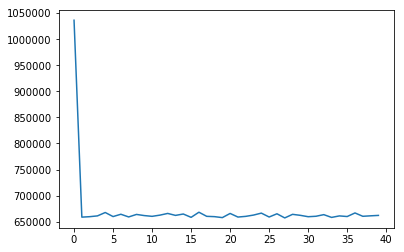

In [83]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=16, verbose=True):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        #instantiate a saver object
        saver = tf.train.Saver()

        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
            save_path = saver.save(sess, 'binary_seq.ckpt')

    return training_losses


training_losses = train_network(10,num_steps, state_size = 16)
plt.plot(training_losses)

In [100]:
graph = tf.Graph()
with graph.as_default():
    #add in a primer so we can generate a sequence
    primer = tf.placeholder(tf.float32, [1, num_steps, n_time_series])
    
    init_state = tf.zeros([1, state_size])   

    rnn_inputs = tf.unstack(primer,axis = 1)

    with tf.variable_scope('rnn_cell'):
        W = tf.get_variable('W', [n_time_series + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

    def rnn_cell(rnn_input, state):
        with tf.variable_scope('rnn_cell', reuse=True):
            W = tf.get_variable('W', [n_time_series + state_size, state_size])
            b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)
    
    #Throw the primer through the rnn_cell

    """
    Adding rnn_cells to graph

    This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
    Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
    """
    state = init_state
    rnn_outputs = []
    for rnn_input in rnn_inputs:
        state = rnn_cell(rnn_input, state)
        rnn_outputs.append(state)
    final_state = rnn_outputs[0]
    
    

    """
    Predictions, loss, training step

    Losses is similar to the "sequence_loss"
    function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
    """

    #logits and predictions
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, 1])
        b = tf.get_variable('b', [1], initializer=tf.constant_initializer(0.0))
    predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
    
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, './binary_seq.ckpt')
    training_state = np.zeros((1,state_size))
    data = gen_data()
    X, Y = data
    primer_ = X.T[:num_steps,:]
    primer_ = primer_[np.newaxis, :, :]
    print (primer_.shape)
    forecast = primer_
    for i in range(20):
        print (forecast.shape, i)
        feed_dict = {primer : forecast, init_state: training_state  }
        preds, training_state = session.run([predictions, final_state], feed_dict = feed_dict)
        forecast = [int(np.argmax(prediction, axis = 1)) for prediction in preds]
        forecast =  np.array(forecast)[np.newaxis, :]
        print (Y)
        print (preds)

(1, 10, 4)
(1, 10, 4) 0
[10 22 29 ..., 21 24 25]
[array([[ 17.29883003]], dtype=float32), array([[ 18.0242157]], dtype=float32), array([[ 18.02471924]], dtype=float32), array([[ 18.02365875]], dtype=float32), array([[ 18.02242088]], dtype=float32), array([[ 18.0228405]], dtype=float32), array([[ 18.02455139]], dtype=float32), array([[ 18.01909065]], dtype=float32), array([[ 18.02340126]], dtype=float32), array([[ 18.02129173]], dtype=float32)]
(1, 10) 1


ValueError: Cannot feed value of shape (1, 10) for Tensor 'Placeholder:0', which has shape '(1, 10, 4)'